#Importing the Libraries and Preparing the Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Load Training Data
air_training = pd.read_csv("/content/train.csv")


#Eliminate specific columns from training data based on Correlation Matrix
columns_to_drop = ['id', 'Gender', 'Gate location', 'Departure/Arrival time convenient',
                   'Arrival Delay in Minutes', 'Departure Delay in Minutes','Unnamed: 0']
air_training.drop(columns=columns_to_drop, inplace=True)

# Convert categorical columns to numeric
label_encoder = LabelEncoder()
air_training['Customer Type'] = label_encoder.fit_transform(air_training['Customer Type'])
air_training['Type of Travel'] = label_encoder.fit_transform(air_training['Type of Travel'])
air_training['Class'] = label_encoder.fit_transform(air_training['Class'])


#Add new columns and set binary values based on 'Class'
air_training['Business'] = np.where(air_training['Class'] == 'Business', 1, 0)
air_training['EcoPlus'] = np.where(air_training['Class'] == 'Eco Plus', 1, 0)

# Drop the original 'Class' column since 'Business' and 'EcoPlus' columns are added
air_training.drop(columns=['Class'], inplace=True)

In [ ]:
# Load Test Data
air_test = pd.read_csv('/content/test.csv')

# Eliminate specific columns from test data
air_test.drop(columns=columns_to_drop, inplace=True)

# Convert categorical columns to numeric for test data
air_test['Customer Type'] = label_encoder.fit_transform(air_test['Customer Type'])
air_test['Type of Travel'] = label_encoder.fit_transform(air_test['Type of Travel'])
air_test['Class'] = label_encoder.fit_transform(air_test['Class'])

# Add new columns and set binary values based on 'Class'
air_test['Business'] = np.where(air_test['Class'] == 'Business', 1, 0)
air_test['EcoPlus'] = np.where(air_test['Class'] == 'Eco Plus', 1, 0)

# Drop the original 'Class' column since 'Business' and 'EcoPlus' columns are added
air_test.drop(columns=['Class'], inplace=True)

#1.Naive Bayes

In [ ]:
X_train = air_training.drop('satisfaction', axis=1)
y_train = air_training['satisfaction']
X_test = air_test.drop('satisfaction', axis=1)
y_test = air_test['satisfaction']

# Create the Gaussian Naive Bayes model
nB = GaussianNB()

# Train the model
nB.fit(X_train, y_train)

# Make predictions on the test data
y_pred = nB.predict(X_test)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

print("Accuracy:", accuracy)

Confusion Matrix:
[[13128  1445]
 [ 2066  9337]]
Accuracy: 0.8648367724052972


#2. KNN Model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

Optimal K: 5


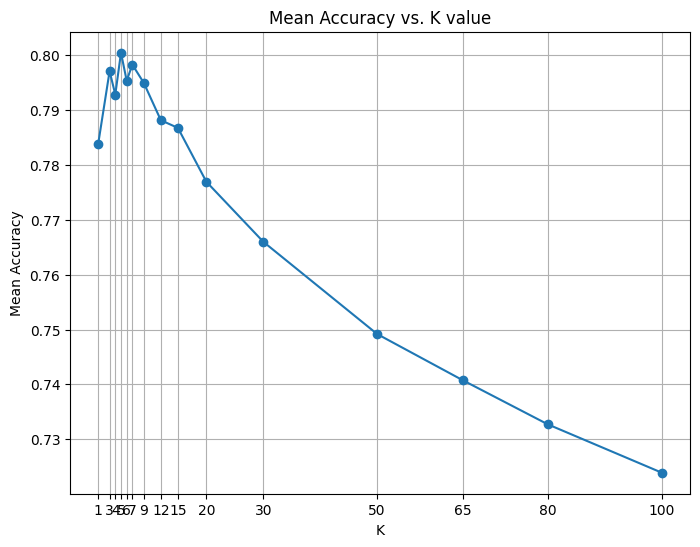

In [ ]:
# K value to test
k_values = [1, 3, 4, 5, 6, 7, 9, 12, 15, 20, 30, 50, 65, 80, 100]

# Perform k-fold cross-validation and record the mean accuracy for each K value
mean_accuracy = []
for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_model, X_train, y_train, cv=5)  # 5-fold cross-validation
    mean_accuracy.append(scores.mean())

# Find the K value that gives the highest accuracy
optimal_k = k_values[np.argmax(mean_accuracy)]
print("Optimal K:", optimal_k)

# Plot the mean accuracy for each K value
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(k_values, mean_accuracy, marker='o')
plt.xlabel('K')
plt.ylabel('Mean Accuracy')
plt.title('Mean Accuracy vs. K value')
plt.xticks(k_values)
plt.grid(True)
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and fit the KNN model
knn_model = KNeighborsClassifier(n_neighbors=optimal_k)
knn_model.fit(X_train_scaled, y_train)

# Predict using the KNN model
knn_pred = knn_model.predict(X_test_scaled)

# Calculate the accuracy
accuracy = accuracy_score(y_test, knn_pred)
print("KNN Accuracy:", accuracy)

# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, knn_pred)
print("Confusion Matrix:")
print(conf_matrix)

#3. CART

In [ ]:
from sklearn.tree import DecisionTreeClassifier,plot_tree, export_graphviz
import pydotplus
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import  GridSearchCV

In [ ]:
CART_class = DecisionTreeClassifier(random_state=10)

# Define the parameters for GridSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None,5,7, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Perform GridSearchCV
grid_search = GridSearchCV(CART_class, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

# Fit the best model on the training data
best_model.fit(X_train, y_train)


# Export the tree created by best_model and save it
dot_data = export_graphviz(best_model, out_file=None, feature_names=air_training.drop('satisfaction', axis=1).columns,
                           class_names=['neutral or dissatisfied', 'satisfied'], filled=True, rounded=True,
                           special_characters=True)

# Save the DOT file
with open('decision_tree_max_depth.dot', 'w') as f:
    f.write(dot_data)

# Convert the DOT file to a PNG image
graph = pydotplus.graph_from_dot_file('decision_tree_max_depth.dot')
graph.write_png('decision_tree_max_depth.png')


# CART Predictions
CART_predict = best_model.predict(air_test.drop('satisfaction', axis=1))

# Confusion Matrix
cm = confusion_matrix(air_test['satisfaction'], CART_predict)

# Classification Report
print("Classification Report:")
print(classification_report(air_test['satisfaction'], CART_predict))


#4. Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import GridSearchCV

In [ ]:
fit = RandomForestClassifier(random_state=10)

# Define the hyperparameters for grid search
param_grid = {
    'n_estimators': [100, 200],  # Number of trees in the forest
     'max_depth': [None,10,20],  # Maximum depth of the tree
     'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
     'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required to be at a leaf node
}

# Perform grid search cross-validation
grid_search = GridSearchCV(fit, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and the corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_


# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_params)

In [ ]:
best_model.fit(X_train, y_train)


# Get feature importances
importances = best_model.feature_importances_
feature_names = X_train.columns



# Print feature importances
print("Feature Importances:")
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance}")



# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create a feature importance plot
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_importances, y=sorted_feature_names)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()


# Score the RandomForestClassifier on the test data
y_pred = best_model.predict(X_test)

# Calculate accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("\n ******************************* \n")
print("Accuracy:", accuracy)
print("\n ******************************* \n")
print("Confusion Matrix:")
print(conf_matrix)


##  5. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
!pip install dmba

from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score

In [ ]:
# Define the Model
log_reg = LogisticRegression()

# Fit the model to the training data
log_reg.fit(X_train, y_train)


# Create and print a table for displaying coef and p-values of the features
print(pd.DataFrame({'coef': log_reg.coef_[0]}, index=X_train.columns))
log_reg_prob = log_reg.predict_proba(X_test)
log_reg_pred = log_reg.predict(X_test)
log_result = pd.DataFrame({'actual' : y_test,
                             'p_0' : [p[0] for p in log_reg_prob],
                             'p_1' : [p[1] for p in log_reg_prob],
                             'predicted': log_reg_pred})
log_result

#Display the odds ratio for each variable
pd.DataFrame({'coef' : log_reg.coef_[0], 'odds' : np.e**log_reg.coef_[0]}, index=X_train.columns)


# Print summary report for the model
classificationSummary(y_test, log_reg.predict(X_test))


#5.1 Forward and Backward Regression Models

In [ ]:
# Define the forward selection method
def forward_selection(X_train, X_test, y_train, y_test):
    selected_features = []
    best_accuracy = 0.0

    while True:
        best_feature = None
        for feature in X_train.columns:
            if feature not in selected_features:
                features_to_try = selected_features + [feature]

                model = LogisticRegression()
                model.fit(X_train[features_to_try], y_train)

                y_pred = model.predict(X_test[features_to_try])
                accuracy = accuracy_score(y_test, y_pred)

                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_feature = feature

        if best_feature is None:
            break

        selected_features.append(best_feature)
        print(f"Selected feature: {best_feature}, Accuracy: {best_accuracy:.4f}")

    return selected_features


# Define the backward elimination method
def backward_elimination(X_train, X_test, y_train, y_test):
    selected_features = list(X_train.columns)
    best_accuracy = 0.0

    while len(selected_features) > 0:
        worst_feature = None
        for feature in selected_features:
            features_to_try = [f for f in selected_features if f != feature]

            model = LogisticRegression()
            model.fit(X_train[features_to_try], y_train)

            y_pred = model.predict(X_test[features_to_try])
            accuracy = accuracy_score(y_test, y_pred)

            if accuracy > best_accuracy:
                best_accuracy = accuracy
                worst_feature = feature

        if worst_feature is None:
            break

        selected_features.remove(worst_feature)
        print(f"Removed feature: {worst_feature}, Accuracy: {best_accuracy:.4f}")

    return selected_features

# Perform forward selection
selected_features_forward = forward_selection(X_train, X_test, y_train, y_test)
print("Selected features (forward selection):", selected_features_forward)

# Perform backward elimination
selected_features_backward = backward_elimination(X_train, X_test, y_train, y_test)
print("Selected features (backward elimination):", selected_features_backward)